# Análise de Redes de Voos no Brasil — Ano de 2024

## Objetivo Geral

Este notebook tem como objetivo aplicar conceitos de análise de redes complexas aos voos realizados no Brasil em 2024, com o intuito de compreender padrões de conectividade aérea entre cidades, hubs logísticos, e possíveis fragilidades ou oportunidades de malha.

## Sobre o Conjunto de Dados

- A fonte primária é a base [VRA da ANAC](https://sistemas.anac.gov.br/dadosabertos/Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/Voo%20Regular%20Ativo%20%28VRA%29/), que registra voos com:
 - Código ICAO das empresas e aeródromos
 - Horários previstos e reais
 - Situação do voo (realizado, cancelado)
 - Companhia aérea
- Complementos:
 - OurAirports: mapeamento ICAO → cidade/pais
 - GeoNames: coordenadas e população das cidades
 - Correções manuais e complementos via [LatLong.net](https://www.latlong.net/)

## 1. Importação dos Dados

Importa bibliotecas essenciais e permite o upload manual de múltiplos arquivos CSV da ANAC via Colab.

In [ ]:
import pandas as pd
import io

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving VRA_202412.csv to VRA_202412 (1).csv
Saving VRA_202411.csv to VRA_202411 (1).csv
Saving VRA_202410.csv to VRA_202410 (1).csv
Saving VRA_20247.csv to VRA_20247 (1).csv
Saving VRA_20249.csv to VRA_20249 (1).csv
Saving VRA_20248.csv to VRA_20248 (1).csv
Saving VRA_20246.csv to VRA_20246 (1).csv
Saving VRA_20245.csv to VRA_20245 (1).csv
Saving VRA_20244.csv to VRA_20244 (1).csv
Saving VRA_20243.csv to VRA_20243 (1).csv
Saving VRA_20242.csv to VRA_20242 (1).csv
Saving VRA_20241.csv to VRA_20241 (1).csv


Lê múltiplos arquivos CSV da ANAC e concatena em um único DataFrame.

In [ ]:
# Lista para armazenar os DataFrames
dfs = []

# Lê todos os arquivos enviados pelo usuário
for filename in uploaded.keys():
    df = pd.read_csv(
        io.BytesIO(uploaded[filename]),
        sep=None,
        engine='python',
        encoding='latin1',
        skiprows=1, # Ignora a primeira linha (cabeçalho extra)
        header=0    # Usa a segunda linha como cabeçalho
    )
    dfs.append(df)

# Concatena todos os DataFrames lidos
df_total = pd.concat(dfs, ignore_index=True)

Confirma a estrutura do DataFrame e visualiza colunas e tipos de dados. Isso revela dados sujos e colunas irrelevantes para a análise de redes.

In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987868 entries, 0 to 987867
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ICAO Empresa AÃ©rea         987868 non-null  object 
 1   NÃºmero Voo                 987868 non-null  object 
 2   CÃ³digo AutorizaÃ§Ã£o (DI)  987868 non-null  object 
 3   CÃ³digo Tipo Linha          987867 non-null  object 
 4   ICAO AerÃ³dromo Origem      987868 non-null  object 
 5   ICAO AerÃ³dromo Destino     987868 non-null  object 
 6   Partida Prevista            955925 non-null  object 
 7   Partida Real                944715 non-null  object 
 8   Chegada Prevista            955923 non-null  object 
 9   Chegada Real                944715 non-null  object 
 10  SituaÃ§Ã£o Voo              987868 non-null  object 
 11  CÃ³digo Justificativa       0 non-null       float64
dtypes: float64(1), object(11)
memory usage: 90.4+ MB


## 2. Pré-processamento

Renomeia as colunas com nomes amigáveis para facilitar o entendimento.

In [ ]:
df_total.columns = [
    "ICAO_Empresa_Aerea",
    "Numero_Voo",
    "Codigo_Autorizacao_DI",
    "Codigo_Tipo_Linha",
    "ICAO_Aerodromo_Origem",
    "ICAO_Aerodromo_Destino",
    "Partida_Prevista",
    "Partida_Real",
    "Chegada_Prevista",
    "Chegada_Real",
    "Situacao_Voo",
    "Codigo_Justificativa"
]

Filtra apenas os voos realmente executados e descarta dados irrelevantes para a rede.

In [ ]:
# Mantém apenas voos realizados e remove colunas desnecessárias
df_total = df_total.drop_duplicates()
df_realizados = df_total[df_total['Situacao_Voo'] == 'REALIZADO']
df_realizados = df_realizados.drop(columns=["Numero_Voo", "Codigo_Autorizacao_DI", "Codigo_Tipo_Linha", "Partida_Prevista", "Partida_Real",
                                            "Chegada_Prevista", "Chegada_Real", "Situacao_Voo", "Codigo_Justificativa"])

Agora temos um dataset enxuto com apenas os ICAOs e empresa aérea.

In [ ]:
df_realizados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 944714 entries, 0 to 987867
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ICAO_Empresa_Aerea      944714 non-null  object
 1   ICAO_Aerodromo_Origem   944714 non-null  object
 2   ICAO_Aerodromo_Destino  944714 non-null  object
dtypes: object(3)
memory usage: 28.8+ MB


Carrega a base de aeroportos do [OurAirports](https://ourairports.com/data/airports.csv) com identificadores ICAO.

In [ ]:
uploaded = files.upload()
airports_df = pd.read_csv('airports.csv')
airports_df

Saving airports.csv to airports.csv


id    ident            type                       name  \
0        6523      00A        heliport          Total RF Heliport   
1      323361     00AA   small_airport       Aero B Ranch Airport   
2        6524     00AK   small_airport               Lowell Field   
3        6525     00AL   small_airport               Epps Airpark   
4      506791     00AN   small_airport       Katmai Lodge Airport   
...       ...      ...             ...                        ...   
83263   32753     ZYYY  medium_airport    Shenyang Dongta Airport   
83264   46378  ZZ-0001        heliport            Sealand Helipad   
83265  307326  ZZ-0002   small_airport  Glorioso Islands Airstrip   
83266  346788  ZZ-0003   small_airport      Fainting Goat Airport   
83267  313629     ZZZZ   small_airport     Satsuma Iōjima Airport   

       latitude_deg  longitude_deg  elevation_ft continent iso_country  \
0         40.070985     -74.933689          11.0       NaN          US   
1         38.704022    -101.473911        3435.0       NaN          US   
2         59.947733    -151.692524         450.0       NaN          US   
3         34.864799     -86.770302         820.0       NaN          US   
4         59.093287    -156.456699          80.0       NaN          US   
...             ...            ...           ...       ...         ...   
83263     41.784401     123.496002           NaN        AS          CN   
83264     51.894444       1.482500          40.0        EU          GB   
83265    -11.584278      47.296389          11.0        AF          TF   
83266     32.110587     -97.356312         690.0       NaN          US   
83267     30.784722     130.270556         338.0        AS          JP   

      iso_region      municipality scheduled_service icao_code iata_code  \
0          US-PA          Bensalem                no       NaN       NaN   
1          US-KS             Leoti                no       NaN       NaN   
2          US-AK      Anchor Point                no       NaN       NaN   
3          US-AL           Harvest                no       NaN       NaN   
4          US-AK       King Salmon                no       NaN       NaN   
...          ...               ...               ...       ...       ...   
83263      CN-21  Dadong, Shenyang                no       NaN       NaN   
83264     GB-ENG           Sealand                no       NaN       NaN   
83265     TF-U-A  Grande Glorieuse                no       NaN       NaN   
83266      US-TX              Blum                no       NaN       NaN   
83267      JP-46           Mishima                no       NaN       NaN   

      gps_code local_code                                          home_link  \
0         K00A        00A  https://www.penndot.pa.gov/TravelInPA/airports...   
1         00AA       00AA                                                NaN   
2         00AK       00AK                                                NaN   
3         00AL       00AL                                                NaN   
4         00AN       00AN                                                NaN   
...        ...        ...                                                ...   
83263     ZYYY        NaN                                                NaN   
83264      NaN        NaN                         http://www.sealandgov.org/   
83265      NaN        NaN                                                NaN   
83266     87TX       87TX                                                NaN   
83267     RJX7       RJX7                                                NaN   

                                          wikipedia_link              keywords  
0                                                    NaN                   NaN  
1                                                    NaN                   NaN  
2                                                    NaN                   NaN  
3                                                    NaN                   NaN  
4             

In [ ]:
# Seleciona e renomeia colunas relevantes
airports = airports_df[[
    'ident', 'municipality', 'iso_country'
]].rename(columns={
    'ident': 'ICAO',
    'municipality': 'Cidade',
    'iso_country': 'Pais'
})

# Visualiza os primeiros registros
airports.head()

ICAO        Cidade Pais
0   00A      Bensalem   US
1  00AA         Leoti   US
2  00AK  Anchor Point   US
3  00AL       Harvest   US
4  00AN   King Salmon   US

Correções manuais para alinhar os ICAOs ao padrão da ANAC.

In [ ]:
airports['ICAO'] = airports['ICAO'].replace('BR-0569', 'SBVC')
airports['ICAO'] = airports['ICAO'].replace('SBMI', 'SDMC')
airports['ICAO'] = airports['ICAO'].replace('BR-2926', 'SSGG')
airports['ICAO'] = airports['ICAO'].replace('BR-0263', 'SJZA')
airports['ICAO'] = airports['ICAO'].replace('SYGO', 'SYEC')
airports['ICAO'] = airports['ICAO'].replace('BR-1021', 'SIUA')
airports['ICAO'] = airports['ICAO'].replace('SBBT', 'SNBA')
airports['ICAO'] = airports['ICAO'].replace('BR-0856', 'SIFC')
airports['ICAO'] = airports['ICAO'].replace('BR-0535', 'SDVZ')
airports['ICAO'] = airports['ICAO'].replace('OKKK', 'OKBK')
airports['ICAO'] = airports['ICAO'].replace('BR-1801', 'SSQO')

In [ ]:
# Adiciona cidade e país da ORIGEM ao DataFrame de voos
df_realizados = df_realizados.merge(
    airports[['ICAO', 'Cidade', 'Pais']],
    how='left',
    left_on='ICAO_Aerodromo_Origem',
    right_on='ICAO'
).rename(columns={'Cidade': 'Origem_Cidade', 'Pais': 'Origem_Pais'}).drop(columns=['ICAO'])

# Adiciona cidade e país do DESTINO
df_realizados = df_realizados.merge(
    airports[['ICAO', 'Cidade', 'Pais']],
    how='left',
    left_on='ICAO_Aerodromo_Destino',
    right_on='ICAO'
).rename(columns={'Cidade': 'Destino_Cidade', 'Pais': 'Destino_Pais'}).drop(columns=['ICAO'])

df_realizados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944714 entries, 0 to 944713
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ICAO_Empresa_Aerea      944714 non-null  object
 1   ICAO_Aerodromo_Origem   944714 non-null  object
 2   ICAO_Aerodromo_Destino  944714 non-null  object
 3   Origem_Cidade           941950 non-null  object
 4   Origem_Pais             941950 non-null  object
 5   Destino_Cidade          941829 non-null  object
 6   Destino_Pais            941829 non-null  object
dtypes: object(7)
memory usage: 50.5+ MB


Agora temos cidades e países associados à origem e destino de cada voo.

In [ ]:
# Identifica ICAOs sem mapeamento
icao_sem_origem = df_realizados[df_realizados['Origem_Cidade'].isna()]['ICAO_Aerodromo_Origem'].unique()
print("ICAOs de origem não encontrados:", len(icao_sem_origem))
print(icao_sem_origem)
icao_sem_destino = df_realizados[df_realizados['Destino_Cidade'].isna()]['ICAO_Aerodromo_Destino'].unique()
print("ICAOs de destino não encontrados:", len(icao_sem_destino))
print(icao_sem_destino)

ICAOs de origem não encontrados: 3
['SBMI' 'SPJC' 'SNRJ']
ICAOs de destino não encontrados: 4
['SBMI' 'SPJC' 'GQNN' 'SNRJ']


In [ ]:
# Preenche valores ausentes com dicionário manual de correções
correcoes = {
    'SBMI': ('Maricá', 'BR'),
    'SPJC': ('Callao', 'PE'),
    'SNRJ': ('Juruti', 'BR'),
    'GQNN': ('Nouakchott', 'MR')
}

In [ ]:
# Aplica correções para origem
for icao, (cidade, pais) in correcoes.items():
    mask = df_realizados['ICAO_Aerodromo_Origem'] == icao
    df_realizados.loc[mask, 'Origem_Cidade'] = cidade
    df_realizados.loc[mask, 'Origem_Pais'] = pais

In [ ]:
# Aplica correções para destino
for icao, (cidade, pais) in correcoes.items():
    mask = df_realizados['ICAO_Aerodromo_Destino'] == icao
    df_realizados.loc[mask, 'Destino_Cidade'] = cidade
    df_realizados.loc[mask, 'Destino_Pais'] = pais

In [ ]:
df_realizados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944714 entries, 0 to 944713
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ICAO_Empresa_Aerea      944714 non-null  object
 1   ICAO_Aerodromo_Origem   944714 non-null  object
 2   ICAO_Aerodromo_Destino  944714 non-null  object
 3   Origem_Cidade           944714 non-null  object
 4   Origem_Pais             944714 non-null  object
 5   Destino_Cidade          944714 non-null  object
 6   Destino_Pais            944714 non-null  object
dtypes: object(7)
memory usage: 50.5+ MB


Elimina duplicidades causadas por acentuação, nomes alternativos ou formatações ambíguas.

In [ ]:
# Corrige nomes de cidades para padronização
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Arnavutköy, Istanbul', 'Istanbul')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Arnavutköy, Istanbul', 'Istanbul')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Bogota', 'Bogotá')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Bogota', 'Bogotá')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Buenos Aires (Ezeiza)', 'Buenos Aires')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Buenos Aires (Ezeiza)', 'Buenos Aires')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Caxias Do Sul', 'Caxias do Sul')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Caxias Do Sul', 'Caxias do Sul')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Cincinnati / Covington', 'Cincinnati')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Cincinnati / Covington', 'Cincinnati')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Concepcion', 'Concepción')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Concepcion', 'Concepción')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Cordoba', 'Córdoba')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Cordoba', 'Córdoba')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Cruzeiro Do Sul', 'Cruzeiro do Sul')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Cruzeiro Do Sul', 'Cruzeiro do Sul')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Dallas-Fort Worth', 'Dallas')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Dallas-Fort Worth', 'Dallas')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Dulles', 'Chantilly')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Dulles', 'Chantilly')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Eldorado Do Sul', 'Eldorado do Sul')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Eldorado Do Sul', 'Eldorado do Sul')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Ferno (VA)', 'Varese')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Ferno (VA)', 'Varese')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Gran Canaria Island', 'Gran Canaria')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Gran Canaria Island', 'Gran Canaria')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('La Serena-Coquimbo', 'La Serena')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('La Serena-Coquimbo', 'La Serena')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Montichiari (BS)', 'Montichiari')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Montichiari (BS)', 'Montichiari')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('New York', 'New York City')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('New York', 'New York City')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Ogle', 'Georgetown')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Ogle', 'Georgetown')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Palma de Mallorca', 'Palma')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Palma de Mallorca', 'Palma')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Paris (Orly, Val-de-Marne)', 'Paris')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Paris (Orly, Val-de-Marne)', 'Paris')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace("Paris (Roissy-en-France, Val-d'Oise)", 'Paris')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace("Paris (Roissy-en-France, Val-d'Oise)", 'Paris')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Porto De Moz', 'Porto de Moz')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Porto De Moz', 'Porto de Moz')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Providencia', 'Isla de Providencia')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Providencia', 'Isla de Providencia')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Puerto Ordaz-Ciudad Guayana', 'Ciudad Guayana')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Puerto Ordaz-Ciudad Guayana', 'Ciudad Guayana')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Querétaro', 'Santiago de Querétaro')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Querétaro', 'Santiago de Querétaro')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Rio De Janeiro', 'Rio de Janeiro')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Rio De Janeiro', 'Rio de Janeiro')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('San José (Alajuela)', 'San José')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('San José (Alajuela)', 'San José')
df_realizados.loc[(df_realizados['Origem_Cidade'] == 'Santa Cruz') & (df_realizados['Origem_Pais'] == 'BO'), 'Origem_Cidade'] = 'Santa Cruz de la Sierra'
df_realizados.loc[(df_realizados['Destino_Cidade'] == 'Santa Cruz') & (df_realizados['Destino_Pais'] == 'BO'), 'Destino_Cidade'] = 'Santa Cruz de la Sierra'
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Santa Cruz Do Sul', 'Santa Cruz do Sul')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Santa Cruz Do Sul', 'Santa Cruz do Sul')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Santa Isabel Do Rio Negro', 'Santa Isabel do Rio Negro')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Santa Isabel Do Rio Negro', 'Santa Isabel do Rio Negro')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('São José Dos Campos', 'São José dos Campos')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('São José Dos Campos', 'São José dos Campos')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Toulouse/Blagnac', 'Blagnac')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Toulouse/Blagnac', 'Blagnac')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Urucu', 'Coari')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Urucu', 'Coari')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Zurich', 'Zürich')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Zurich', 'Zürich')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Bordeaux/Mérignac', 'Bordeaux')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Bordeaux/Mérignac', 'Bordeaux')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Freetown (Lungi-Town)', 'Lungi')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Freetown (Lungi-Town)', 'Lungi')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Prestwick, South Ayrshire', 'Prestwick')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Prestwick, South Ayrshire', 'Prestwick')
df_realizados['Origem_Cidade'] = df_realizados['Origem_Cidade'].replace('Tarbes/Lourdes/Pyrénées', 'Tarbes')
df_realizados['Destino_Cidade'] = df_realizados['Destino_Cidade'].replace('Tarbes/Lourdes/Pyrénées', 'Tarbes')

Carrega base de dados geográficos [GeoNames](http://download.geonames.org/export/dump/cities15000.zip) que abrange todos os países e contém todas as cidades com população > 15.000 ou capitais.

In [ ]:
uploaded = files.upload()

Saving cities15000.txt to cities15000.txt


In [ ]:
# Carrega base GeoNames de cidades
colunas = ['geonameid', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude',
           'feature_class', 'feature_code', 'country_code', 'cc2', 'admin1_code',
           'admin2_code', 'admin3_code', 'admin4_code', 'population', 'elevation',
           'dem', 'timezone', 'modification_date']

geonames = pd.read_csv("cities15000.txt", sep='\t', names=colunas)

# Mantém apenas as colunas necessárias
geonames = geonames[['name', 'country_code', 'latitude', 'longitude', 'population']]
geonames.columns = ['Cidade', 'Pais', 'Latitude', 'Longitude', 'population']

In [ ]:
# Eliminar cidades duplicadas, mantendo a mais populosa
geonames_dedup = geonames.sort_values('population', ascending=False).drop_duplicates(subset=['Cidade', 'Pais'])

# Confirma que há apenas uma linha por cidade+país
assert geonames_dedup.duplicated(subset=['Cidade', 'Pais']).sum() == 0

Para garantir que todas as cidades estejam georreferenciadas, foram feitas correções manuais com o auxílio do [LatLong.net](https://www.latlong.net).

In [ ]:
# Adiciona coordenadas manuais para cidades ausentes
coordenadas_novas = pd.DataFrame({
    'Cidade': ['Alta Floresta', 'Cairu', 'Ciudad de México', 'Ciudad de la Costa', 'Cruz', 'Fernando de Noronha', 'Fujairah', 'Gran Canaria', 'Grâce-Hollogne',
               'Isla de Providencia', 'Ji-Paraná', 'Lençóis', 'Lungi', 'Maraú', 'Porto Murtinho', 'Prestwick', 'Punta del Este', 'Rabil', 'Santa Isabel do Rio Negro',
               'Setubinha', 'Shannon', 'Teixeira de Freitas', 'Tenerife', 'Yundum', 'Zandery'],
    'Pais': ['BR', 'BR', 'MX', 'UY', 'BR', 'BR', 'AE', 'ES', 'BE', 'CO', 'BR', 'BR', 'SL', 'BR', 'BR', 'GB', 'UY', 'CV', 'BR', 'BR', 'IE', 'BR', 'ES', 'GM', 'SR'],
    'Latitude': [-9.877010, -13.487320, 19.432608, -34.827942, -2.910811, -3.844798, 25.124460, 28.124830, 50.642941, 13.358057, -10.882868, -12.562930, 8.614884, -14.103520,
                 -21.697630, 55.505810, -34.936878, 16.125846, -0.414170, -17.595961, 52.710095, -17.538470, 28.291565, 13.342900, 5.455910],
    'Longitude': [-56.085571, -39.044220, -99.133209, -55.953098, -40.173752, -32.426891, 56.335510, -15.430020, 5.500130, -81.359757, -61.930373, -41.390629, -13.191392,
                  -39.015295, -57.881222, -4.605670, -54.928150, -22.889185, -65.019943, -42.165379, -8.881663, -39.738560, -16.629129, -16.667311, -55.204781],
    'population': [58613.0, 17761.0, 9209944.0, 83888.0, 29761.0, 3167.0, 92226.0, 843158.0, 21779.0, 5000.0, 131026.0, 11170.0, 4185.0, 21098.0, 12859.0, 14880.0, 12423.0,
                   16621.0, 26566.0, 9917.0, 10256.0, 145216.0, 965857.0, 13000.0, 6113.0]
})

In [ ]:
geonames_dedup = pd.concat([geonames_dedup, coordenadas_novas], ignore_index=True)

In [ ]:
# Mescla coordenadas com a origem dos voos
df_realizados = df_realizados.merge(
    geonames_dedup.rename(columns={'Cidade': 'Origem_Cidade', 'Pais': 'Origem_Pais'}),
    how='left',
    on=['Origem_Cidade', 'Origem_Pais']
).rename(columns={
    'Latitude': 'Origem_Latitude',
    'Longitude': 'Origem_Longitude'
})

# Mescla coordenadas com o destino dos voos
df_realizados = df_realizados.merge(
    geonames_dedup.rename(columns={'Cidade': 'Destino_Cidade', 'Pais': 'Destino_Pais'}),
    how='left',
    on=['Destino_Cidade', 'Destino_Pais']
).rename(columns={
    'Latitude': 'Destino_Latitude',
    'Longitude': 'Destino_Longitude'
})

df_realizados

ICAO_Empresa_Aerea ICAO_Aerodromo_Origem ICAO_Aerodromo_Destino  \
0                     ACN                  SWLB                   SWKO   
1                     ACN                  SWLB                   SWKO   
2                     ACN                  SBRF                   SNAB   
3                     ACN                  SBRF                   SNAB   
4                     ACN                  SBRF                   SNAB   
...                   ...                   ...                    ...   
964582                TAM                  SBRJ                   SBBR   
964583                TAM                  SBRJ                   SBBR   
964584                TAM                  SBRJ                   SBBR   
964585                TAM                  SBRJ                   SBBR   
964586                TAM                  SBRJ                   SBBR   

         Origem_Cidade Origem_Pais Destino_Cidade Destino_Pais  \
0               Lábrea          BR          Coari           BR   
1               Lábrea          BR          Coari           BR   
2               Recife          BR      Araripina           BR   
3               Recife          BR      Araripina           BR   
4               Recife          BR      Araripina           BR   
...                ...         ...            ...          ...   
964582  Rio de Janeiro          BR       Brasília           BR   
964583  Rio de Janeiro          BR       Brasília           BR   
964584  Rio de Janeiro          BR       Brasília           BR   
964585  Rio de Janeiro          BR       Brasília           BR   
964586  Rio de Janeiro          BR       Brasília           BR   

        Origem_Latitude  Origem_Longitude  population_x  Destino_Latitude  \
0              -7.26435         -64.79638       48927.0          -4.08500   
1              -7.26435         -64.79638       48927.0          -4.08500   
2              -8.05389         -34.88111     1653461.0          -7.57611   
3              -8.05389         -34.88111     1653461.0          -7.57611   
4              -8.05389         -34.88111     1653461.0          -7.57611   
...                 ...               ...           ...               ...   
964582        -22.90642         -43.18223     6747815.0         -15.77972   
964583        -22.90642         -43.18223     6747815.0         -15.77972   
964584        -22.90642         -43.18223     6747815.0         -15.77972   
964585        -22.90642         -43.18223     6747815.0         -15.77972   
964586        -22.90642         -43.18223     6747815.0         -15.77972   

        Destino_Longitude  population_y  
0               -63.14139       73820.0  
1               -63.14139       73820.0  
2               -40.49833       90104.0  
3               -40.49833       90104.0  
4               -40.49833       90104.0  
...                   ...           ...  
964582          -47.92972     2207718.0  
964583          -47.92972     2207718.0  
964584          -47.92972     2207718.0  
964585          -47.92972     2207718.0  
964586          -47.92972     2207718.0  

[964587 rows x 13 columns]

In [ ]:
df_realizados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964587 entries, 0 to 964586
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ICAO_Empresa_Aerea      964587 non-null  object 
 1   ICAO_Aerodromo_Origem   964587 non-null  object 
 2   ICAO_Aerodromo_Destino  964587 non-null  object 
 3   Origem_Cidade           964587 non-null  object 
 4   Origem_Pais             964587 non-null  object 
 5   Destino_Cidade          964587 non-null  object 
 6   Destino_Pais            964587 non-null  object 
 7   Origem_Latitude         964587 non-null  float64
 8   Origem_Longitude        964587 non-null  float64
 9   population_x            964587 non-null  float64
 10  Destino_Latitude        964587 non-null  float64
 11  Destino_Longitude       964587 non-null  float64
 12  population_y            964587 non-null  float64
dtypes: float64(6), object(7)
memory usage: 95.7+ MB


In [ ]:
# Salva o data frame final, para evitar futuras repetições do pré-processamento
df_realizados.to_parquet("voos_realizados2024.parquet", index=False)

In [ ]:
uploaded = files.upload()
voos_realizados2024 = pd.read_parquet("voos_realizados2024.parquet")
voos_realizados2024.head()

Saving voos_realizados2024.parquet to voos_realizados2024 (2).parquet


ICAO_Empresa_Aerea ICAO_Aerodromo_Origem ICAO_Aerodromo_Destino  \
0                ACN                  SWLB                   SWKO   
1                ACN                  SWLB                   SWKO   
2                ACN                  SBRF                   SNAB   
3                ACN                  SBRF                   SNAB   
4                ACN                  SBRF                   SNAB   

  Origem_Cidade Origem_Pais Destino_Cidade Destino_Pais  Origem_Latitude  \
0        Lábrea          BR          Coari           BR         -7.26435   
1        Lábrea          BR          Coari           BR         -7.26435   
2        Recife          BR      Araripina           BR         -8.05389   
3        Recife          BR      Araripina           BR         -8.05389   
4        Recife          BR      Araripina           BR         -8.05389   

   Origem_Longitude  population_x  Destino_Latitude  Destino_Longitude  \
0         -64.79638       48927.0          -4.08500          -63.14139   
1         -64.79638       48927.0          -4.08500          -63.14139   
2         -34.88111     1653461.0          -7.57611          -40.49833   
3         -34.88111     1653461.0          -7.57611          -40.49833   
4         -34.88111     1653461.0          -7.57611          -40.49833   

   population_y  
0       73820.0  
1       73820.0  
2       90104.0  
3       90104.0  
4       90104.0

In [ ]:
voos_realizados2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944714 entries, 0 to 944713
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ICAO_Empresa_Aerea      944714 non-null  object 
 1   ICAO_Aerodromo_Origem   944714 non-null  object 
 2   ICAO_Aerodromo_Destino  944714 non-null  object 
 3   Origem_Cidade           944714 non-null  object 
 4   Origem_Pais             944714 non-null  object 
 5   Destino_Cidade          944714 non-null  object 
 6   Destino_Pais            944714 non-null  object 
 7   Origem_Latitude         944714 non-null  float64
 8   Origem_Longitude        944714 non-null  float64
 9   population_x            944714 non-null  float64
 10  Destino_Latitude        944714 non-null  float64
 11  Destino_Longitude       944714 non-null  float64
 12  population_y            944714 non-null  float64
dtypes: float64(6), object(7)
memory usage: 93.7+ MB


## 3. Construção da Rede

In [ ]:
import networkx as nx

In [ ]:
# Agrupa os dados para contar quantos voos existem entre cada par de cidades (origem → destino)
edges = voos_realizados2024.groupby(['Origem_Cidade', 'Destino_Cidade']).size().reset_index(name='quantidade_voos')

# Constrói a rede direcionada, onde:
# - os nós são cidades
# - as arestas representam voos
# - o peso das arestas é a quantidade de voos entre os pares
G = nx.from_pandas_edgelist(
    edges,
    source='Origem_Cidade',
    target='Destino_Cidade',
    edge_attr='quantidade_voos',
    create_using=nx.DiGraph()
)

print(f"Número de nós: {G.number_of_nodes()}")
print(f"Número de arestas: {G.number_of_edges()}")

Número de nós: 367
Número de arestas: 2753


In [ ]:
# Converte a rede em uma matriz de adjacência ponderada
matriz_adj = nx.to_pandas_adjacency(G, weight='quantidade_voos')
matriz_adj

Abidjan  Brasília  Abu Dhabi  Rio de Janeiro  São Paulo  \
Abidjan             0.0       1.0        0.0             0.0        0.0   
Brasília            0.0     149.0        0.0          5316.0    14024.0   
Abu Dhabi           0.0       0.0        0.0             1.0        1.0   
Rio de Janeiro      0.0    5313.0        0.0           291.0    28657.0   
São Paulo           0.0   14147.0        0.0         28837.0     1126.0   
...                 ...       ...        ...             ...        ...   
Toronto             0.0       0.0        0.0             0.0      370.0   
Cascais             0.0       0.0        0.0             0.0        0.0   
Warwick             0.0       0.0        0.0             1.0        0.0   
Zaragoza            0.0       0.0        0.0             0.0        0.0   
Zhengzhou           0.0       0.0        0.0             0.0        0.0   

                Accra  Campinas  Larnaca   Recife  Salvador  ...  Beirut  \
Abidjan           0.0       0.0      0.0      0.0       0.0  ...     0.0   
Brasília          0.0    2364.0      0.0   2296.0    2036.0  ...     0.0   
Abu Dhabi         0.0       0.0      0.0      0.0       0.0  ...     0.0   
Rio de Janeiro    0.0    5351.0      0.0   3155.0    2991.0  ...     0.0   
São Paulo         0.0     451.0      0.0  10168.0    9284.0  ...     1.0   
...               ...       ...      ...      ...       ...  ...     ...   
Toronto           0.0       0.0      0.0      0.0       0.0  ...     0.0   
Cascais           0.0       0.0      0.0      0.0       0.0  ...     0.0   
Warwick           0.0       0.0      0.0      0.0       0.0  ...     0.0   
Zaragoza          0.0       0.0      0.0      0.0       0.0  ...     0.0   
Zhengzhou         0.0       0.0      0.0      0.0       0.0  ...     0.0   

                Fairfield  San Antonio  San Miguel de Tucumán  \
Abidjan               0.0          0.0                    0.0   
Brasília              0.0          0.0                    0.0   
Abu Dhabi             0.0          0.0                    0.0   
Rio de Janeiro        0.0          0.0                    0.0   
São Paulo             1.0          1.0                    1.0   
...                   ...          ...                    ...   
Toronto               0.0          0.0                    0.0   
Cascais               0.0          0.0                    0.0   
Warwick               0.0          0.0                    0.0   
Zaragoza              0.0          0.0                    0.0   
Zhengzhou             0.0          0.0                    0.0   

                Termas de Río Hondo  Toronto  Cascais  Warwick  Zaragoza  \
Abidjan                         0.0      0.0      0.0      0.0       0.0   
Brasília                        0.0      0.0      0.0      0.0       0.0   
Abu Dhabi                       0.0      0.0      0.0      0.0       0.0   
Rio de Janeiro                  0.0      0.0      0.0      0.0       0.0   
São Paulo                       1.0    365.0      0.0      0.0       0.0   
...                             ...      ...      ...      ...       ...   
Toronto                         0.0      0.0      0.0      0.0       0.0   
Cascais                         0.0      0.0      0.0      0.0       0.0   
Warwick                         0.0      0.0      0.0      0.0       0.0   
Zaragoza                        0.0      0.0      0.0      0.0       0.0   
Zhengzhou                       0.0      0.0      0.0      0.0       0.0   

                Zhengzhou  
Abidjan               0.0  
Brasília              0.0  
Abu Dhabi             0.0  
Rio de Janeiro        0.0  
São Paulo             0.0  
...                   ...  
Toronto               0.0  
Cascais               0.0  
Warwick               0.0  
Zaragoza              0.0  
Zhengzhou             0.0  

[367 rows x 367 columns]

## 4. Métricas da rede

In [ ]:
# Calcula o diâmetro da rede (convertida para não-direcionada)
diametro = nx.diameter(nx.to_undirected(G))

# Identifica os nós mais distantes (periféricos)
periferia = nx.periphery(nx.to_undirected(G))

print(f"Diâmetro: {diametro}")
print(f"Periferia: {periferia}")

Diâmetro: 6
Periferia: ['Narita', 'Bangkok', 'Belgrade', 'Jacareacanga', 'Laredo', 'Sialkot', 'Cascais']


A maior distância entre quaisquer duas cidades é de 6 conexões. A rede é relativamente compacta.

Cidades mais distantes e isoladas: Narita, Bangkok, Belgrade, Jacareacanga, Laredo, Sialkot e Cascais - são os pontos mais extremos da malha aérea.

In [ ]:
# Densidade e Esparsidade
densidade = nx.density(G)
esparsidade = 1 - densidade
print(f"Densidade: {densidade}")
print(f"Esparsidade: {esparsidade}")

Densidade: 0.020495525677104273
Esparsidade: 0.9795044743228958


A densidade é baixa (~0,020), indicando que a maioria dos pares de cidades não têm conexão direta, típico de redes de transporte otimizadas.

In [ ]:
# Assortatividade
assort = nx.degree_assortativity_coefficient(G)
print(f"Assortatividade: {assort}")

Assortatividade: -0.3257751940110209


Valor negativo (~ -0.32) indica uma rede desassortativa: cidades muito conectadas (hubs) tendem a se conectar com cidades pouco conectadas — estrutura em estrela típica de redes logísticas.

In [ ]:
# Clustering global
clustering_global = nx.average_clustering(G.to_undirected())
print(f"Coeficiente de clustering global: {clustering_global}")

# Clustering local
for cidade in ['Rio de Janeiro', 'São Paulo', 'Natal']:
    clustering_local = nx.clustering(G.to_undirected(), cidade)
    print(f"Clustering local para {cidade}: {clustering_local}")

Coeficiente de clustering global: 0.5256305778662564
Clustering local para Rio de Janeiro: 0.12107438016528925
Clustering local para São Paulo: 0.07784431137724551
Clustering local para Natal: 0.4015873015873016


O coeficiente médio de clustering (~0.52) indica alta conectividade local.

- Natal tem alta coesão regional.

- São Paulo e Rio de Janeiro atuam mais como hubs do que como pontos de conexão entre seus vizinhos.

In [ ]:
# Componentes fracamente conectados
comp_fraco = nx.number_weakly_connected_components(G)
print(f"Componentes fracamente conectados: {comp_fraco}")

# Componentes fortemente conectados
comp_forte = nx.number_strongly_connected_components(G)
print(f"Componentes fortemente conectados: {comp_forte}")

Componentes fracamente conectados: 1
Componentes fortemente conectados: 56


1 componente fracamente conectado: indica que, ignorando direção, todas as cidades estão ligadas.

56 componentes fortemente conectados: há fragmentação direcional, com muitas rotas unidirecionais..

In [ ]:
# Calcula as centralidades principais
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G.to_undirected())

# Organiza em um DataFrame
centralidades = pd.DataFrame({
    'Degree': pd.Series(degree),
    'Closeness': pd.Series(closeness),
    'Betweenness': pd.Series(betweenness),
    'Eigenvector': pd.Series(eigenvector)
})

# Exibe os 10 nós mais centrais
centralidades.sort_values('Degree', ascending=False).head(10)

Degree  Closeness  Betweenness  Eigenvector
São Paulo       0.827869   0.571451     0.253561     0.270063
Campinas        0.696721   0.551151     0.177713     0.255233
Rio de Janeiro  0.549180   0.518893     0.098166     0.235656
Belo Horizonte  0.527322   0.511199     0.090864     0.226746
Recife          0.385246   0.484840     0.065016     0.197032
Manaus          0.360656   0.470862     0.111140     0.158725
Brasília        0.355191   0.480337     0.031523     0.198719
Fortaleza       0.322404   0.468021     0.049651     0.174951
Curitiba        0.314208   0.475188     0.033376     0.180355
Salvador        0.289617   0.455650     0.033425     0.155659

- São Paulo lidera em todas as métricas → maior conector do país.

- Campinas também é extremamente relevante.

- Manaus se destaca na intermediação (ponte logística do Norte).

## 5. Visualizações

In [ ]:
# Importa e carrega todas as bibliotecas necessárias para nossas visualizações

import matplotlib.pyplot as plt
import seaborn as sns

!pip install python-louvain
import community.community_louvain as community_louvain

!pip install pyvis
from pyvis.network import Network
from IPython.display import display, HTML
from google.colab import files
import numpy as np
import random

!pip install cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import plotly.graph_objects as go

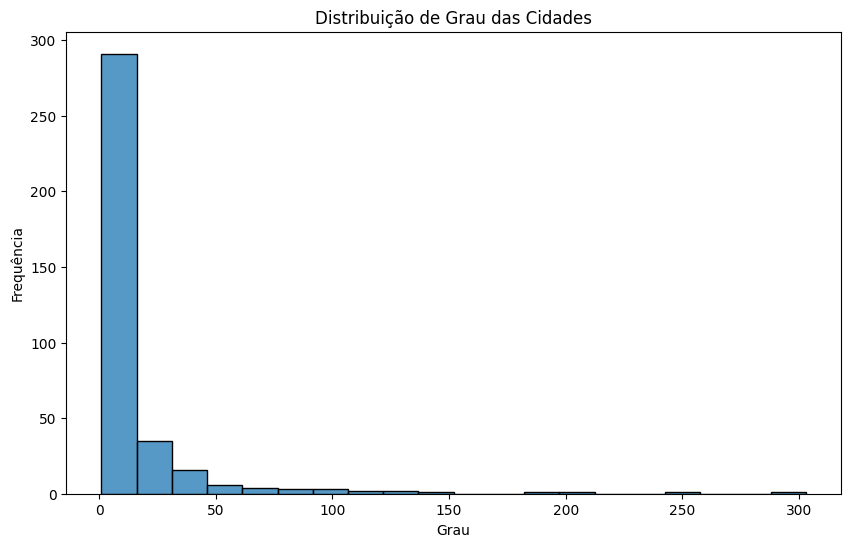

In [ ]:
# Gráfico da distribuição de grau

# Coleta os graus (número de conexões) de cada cidade
graus = [grau for node, grau in G.degree()]

# Plota a distribuição
plt.figure(figsize=(10,6))
sns.histplot(graus, bins=20, kde=False)
plt.title('Distribuição de Grau das Cidades')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.show()

A maioria das cidades tem poucas conexões por voo (grau baixo), enquanto poucas cidades atuam como grandes hubs altamente conectados (grau alto). Essa distribuição assimétrica, com cauda longa à direita, é típica de redes aéreas reais e indica uma estrutura centralizada e eficiente, mas que pode ser vulnerável à falha dos principais hubs.

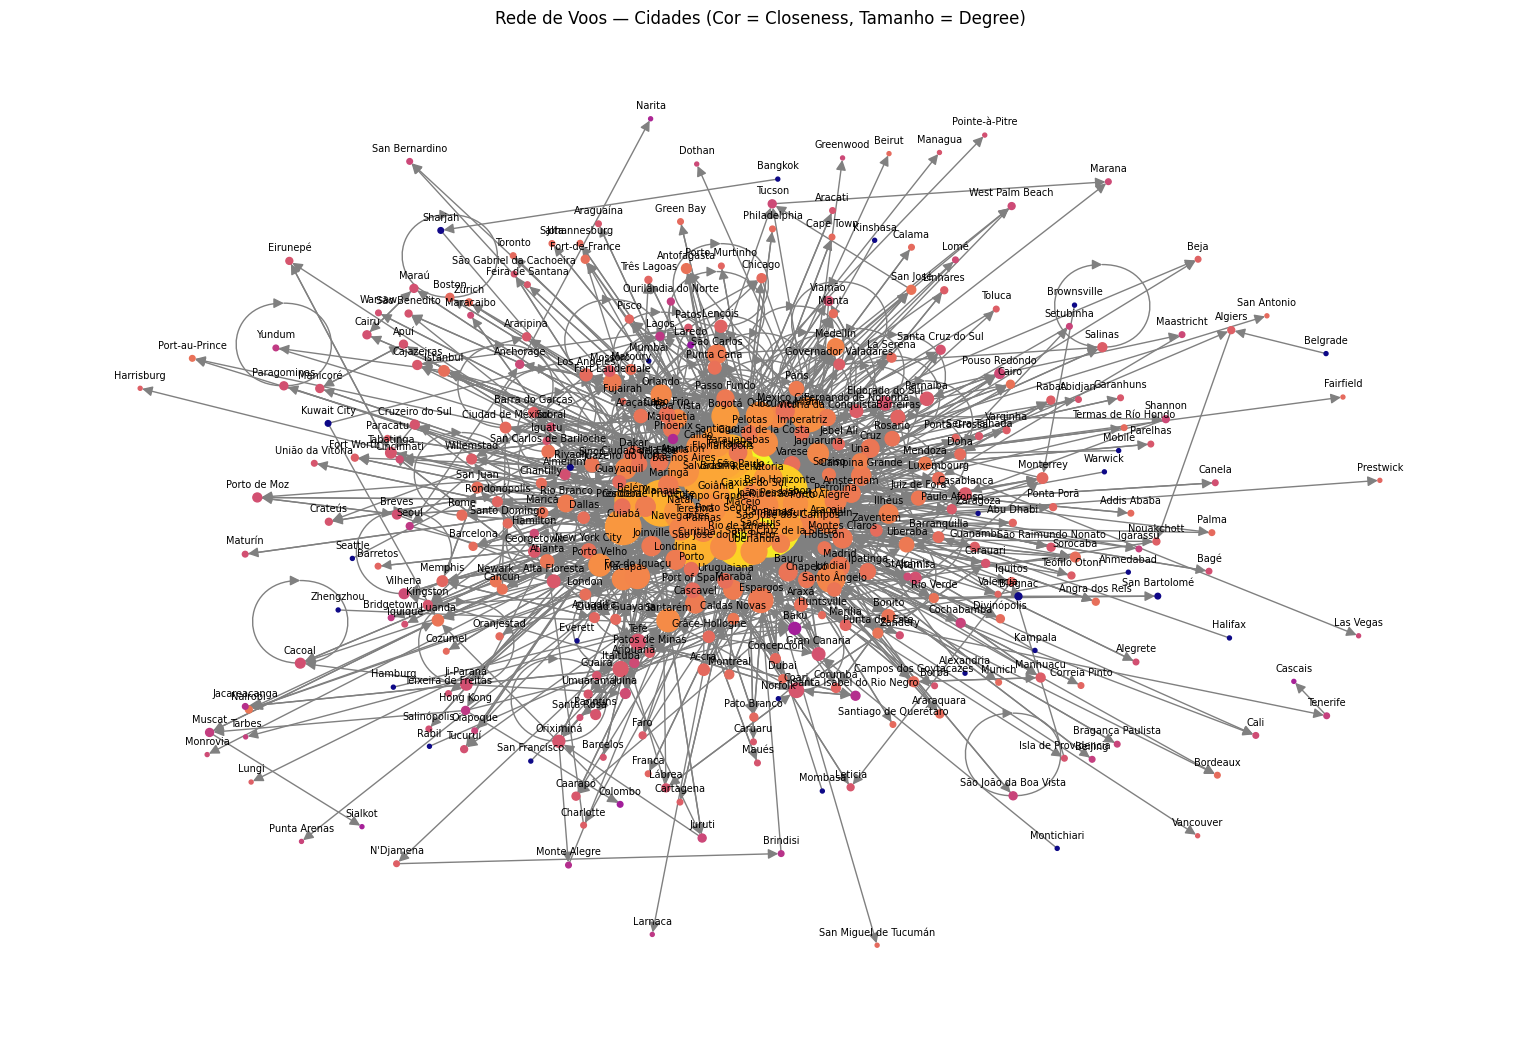

In [ ]:
# Grafo com tamanho dos nós proporcional ao grau e cor pela closeness

plt.figure(figsize=(15, 10))

# Layout que posiciona os nós de forma mais legível (repulsão física)
pos = nx.spring_layout(G, k=0.3)

# Tamanhos dos nós proporcional ao grau
node_sizes = [v * 3000 for v in degree.values()]

# Desenha o grafo sem as labels
nx.draw(
    G, pos,
    with_labels=False,  # desativa as labels automáticas
    node_size=node_sizes,
    node_color=list(closeness.values()),
    cmap=plt.cm.plasma,
    arrowsize=15,
    edge_color='gray'
)

# Ajusta posição das labels (desloca no eixo y)
label_pos = {k: (v[0], v[1] + 0.03) for k, v in pos.items()}  # 0.03 é o deslocamento vertical

nx.draw_networkx_labels(
    G, label_pos,
    font_size=7,
    font_color='black'
)

plt.title('Rede de Voos — Cidades (Cor = Closeness, Tamanho = Degree)')
plt.show()

Cidades com maior grau aparecem maiores; as mais "centrais" em termos de distância aparecem com cores mais brilhantes (alta closeness).

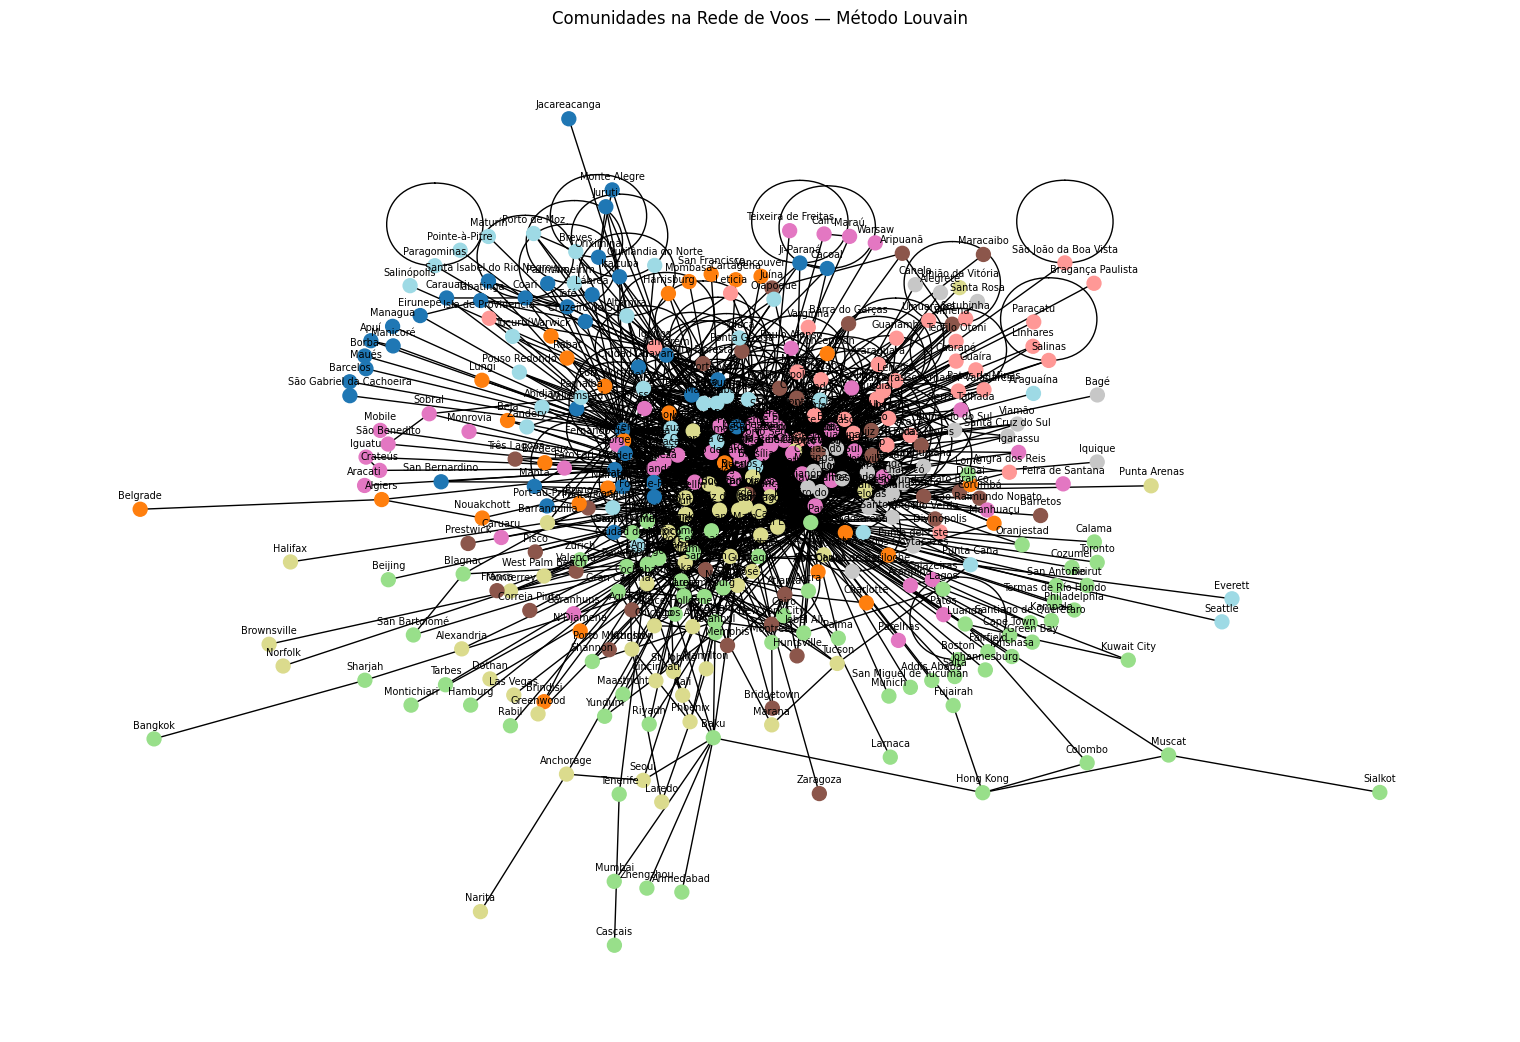

In [ ]:
# Grafo com coloração por comunidades (Método Louvain)

# Converte a rede para não-direcionada para análise de comunidade
G_und = G.to_undirected()

# Executa o algoritmo Louvain
partition = community_louvain.best_partition(G_und)

# Plot das comunidades
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_und)

# Cores para as comunidades
cmap = plt.get_cmap('tab20')

# Desenha o grafo sem labels
nx.draw(
    G_und, pos,
    node_color=[partition[node] for node in G_und.nodes()],
    node_size=100,
    cmap=cmap,
    with_labels=False
)

# Ajusta posição das labels (desloca no eixo y)
label_pos = {k: (v[0], v[1] + 0.03) for k, v in pos.items()}

nx.draw_networkx_labels(
    G_und, label_pos,
    font_size=7,
    font_color='black'
)

plt.title('Comunidades na Rede de Voos — Método Louvain')
plt.show()

In [ ]:
# Criação da visualização com Pyvis
net = Network(height='600px', width='100%', directed=True, notebook=True,
              bgcolor='white', font_color='black')

net.cdn_resources = 'in_line'
net.show_buttons(['physics'])
net.from_nx(G)

# Personalização de nós com métricas
for node in net.nodes:
    node_id = node['id']
    node['title'] = f"Degree: {degree[node_id]:.4f}<br>Closeness: {closeness[node_id]:.4f}"
    node['color'] = '#%06x' % random.randint(0, 0xFFFFFF)
    node['value'] = degree[node_id] * 15
    node['borderWidth'] = 2

# Salva HTML base sem título ainda
output_html = "rede_voos_pyvis.html"
net.show(output_html)

# Lê conteúdo do HTML e insere o título manualmente
titulo_html = """
<h1 style="text-align:center; color:#2c3e50;">✈️ Rede de Voos do Brasil em 2024</h1>
<br>
"""

with open(output_html, "r", encoding="utf-8") as f:
    html_content = f.read()

# Insere o título logo após o <body>
html_content = html_content.replace("<body>", f"<body>\n{titulo_html}")

# Salva o novo HTML
with open(output_html, "w", encoding="utf-8") as f:
    f.write(html_content)

# Exibe no notebook
display(HTML(output_html))

# Opção de download
# files.download(output_html)

rede_voos_pyvis.html


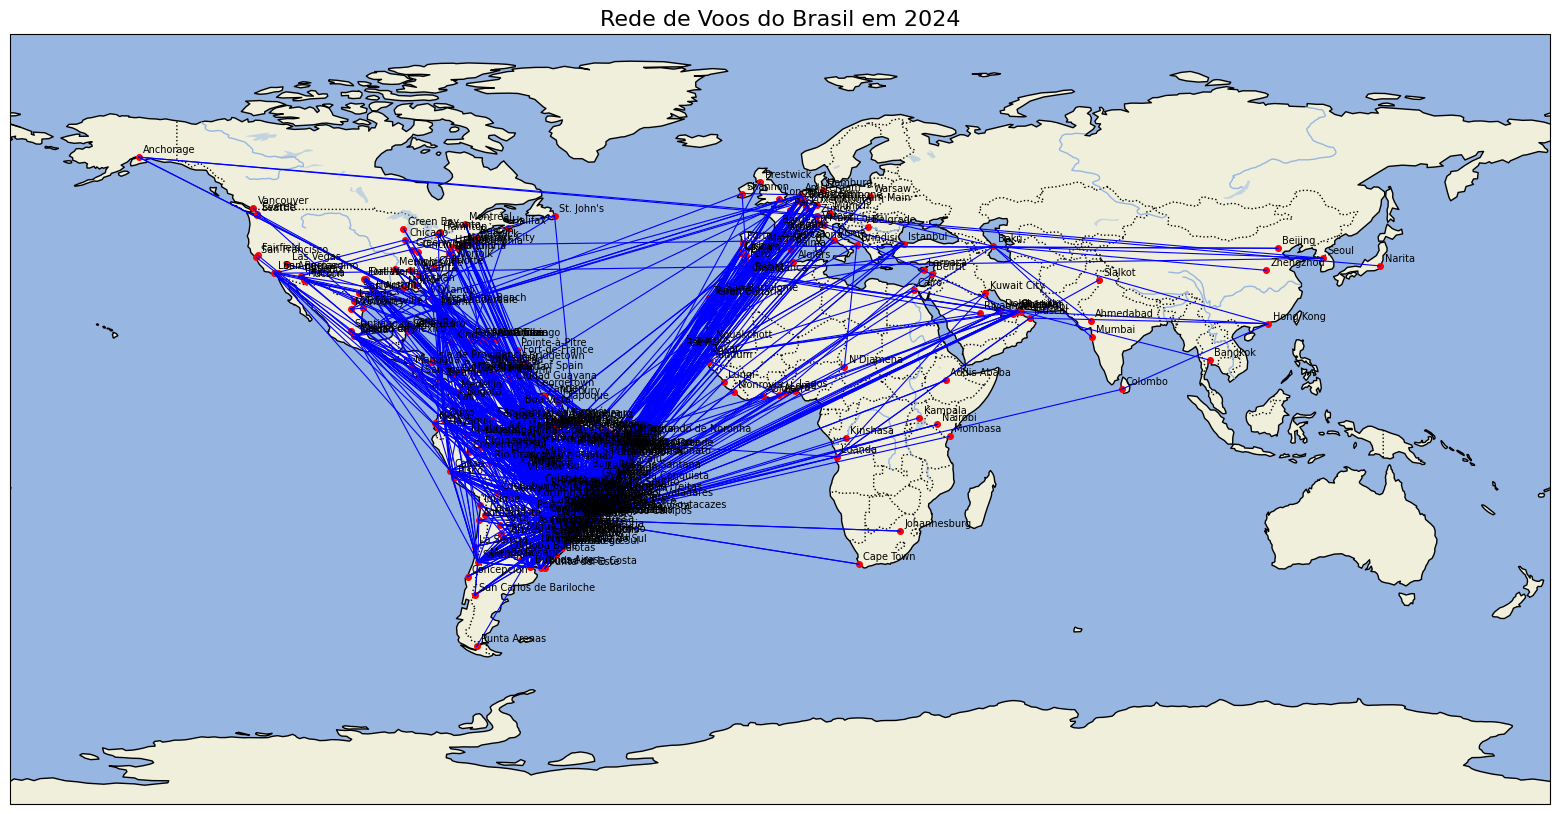

In [ ]:
# Mapa com Cartopy

pos = {}

# Define a posição geográfica dos nós com base nas coordenadas
for index, row in voos_realizados2024.iterrows():
    if pd.notnull(row['Origem_Cidade']) and pd.notnull(row['Origem_Latitude']) and pd.notnull(row['Origem_Longitude']):
        pos[row['Origem_Cidade']] = (row['Origem_Longitude'], row['Origem_Latitude'])
    if pd.notnull(row['Destino_Cidade']) and pd.notnull(row['Destino_Latitude']) and pd.notnull(row['Destino_Longitude']):
        pos[row['Destino_Cidade']] = (row['Destino_Longitude'], row['Destino_Latitude'])

# Adiciona coordenadas aos nós no grafo
for city, (lon, lat) in pos.items():
    G.nodes[city]['Longitude'] = lon
    G.nodes[city]['Latitude'] = lat

# Mapa base
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_extent([-180, 180, -90, 90])

# Adiciona camadas geográficas
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plota cidades e conexões
for city, (lon, lat) in pos.items():
    ax.plot(lon, lat, marker='o', color='red', markersize=4, transform=ccrs.PlateCarree())
    ax.text(lon + 1, lat + 1, city, fontsize=7, transform=ccrs.PlateCarree())

for origin, destination in G.edges():
    if origin in pos and destination in pos:
        lon1, lat1 = pos[origin]
        lon2, lat2 = pos[destination]
        ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=0.8, transform=ccrs.PlateCarree())

plt.title('Rede de Voos do Brasil em 2024', fontsize=16)
plt.show()

In [ ]:
# Mapa Interativo da Rede de Voos com Plotly

# Itera sobre os registros do dataframe original para classificar cada voo como nacional ou internacional
for _, row in voos_realizados2024.iterrows():
    origem = row['Origem_Cidade']
    destino = row['Destino_Cidade']

    # Define o tipo do voo com base no país de origem e destino
    tipo_voo = 'Nacional' if row['Origem_Pais'] == 'BR' and row['Destino_Pais'] == 'BR' else 'Internacional'

    # Adiciona essa informação como atributo na aresta do grafo
    if pd.notnull(origem) and pd.notnull(destino):
        G.add_edge(origem, destino, tipo=tipo_voo)

# Cria as linhas representando os voos (arestas) no mapa

edge_traces = []

for origin, destination in G.edges():
    if origin in pos and destination in pos:            # Apenas se houver coordenadas conhecidas para ambas as cidades
        lon1, lat1 = pos[origin]
        lon2, lat2 = pos[destination]

        # Usa a cor azul para voos nacionais e verde para internacionais
        tipo = G.edges[origin, destination].get('tipo', 'Nacional')
        cor = 'blue' if tipo == 'Nacional' else 'green'

        # Cria o traçado entre duas cidades (linha no mapa)
        edge_traces.append(go.Scattergeo(
            lon=[lon1, lon2, None],                     # None separa as linhas entre traços
            lat=[lat1, lat2, None],
            mode='lines',
            line=dict(width=1, color=cor),
            hoverinfo='text',
            text=f'{origin} → {destination} ({tipo})',  # texto ao passar o mouse
            showlegend=False
        ))

# Adiciona legendas manuais para diferenciar os tipos de voo

edge_traces.append(go.Scattergeo(
    lon=[None], lat=[None],
    mode='lines',
    line=dict(width=2, color='blue'),
    name='Voo Nacional'
))

edge_traces.append(go.Scattergeo(
    lon=[None], lat=[None],
    mode='lines',
    line=dict(width=2, color='green'),
    name='Voo Internacional'
))

# Cálculo do grau e centralidade dos nós (cidades)
degrees = dict(G.degree())
centrality = nx.degree_centrality(G)

# Normaliza o grau para definir tamanho proporcional dos marcadores no mapa
graus = np.array([degrees.get(city, 0) for city in pos.keys()])
graus_normalizados = 5 + 20 * (graus - graus.min()) / (graus.max() - graus.min())  # escala entre 5 e 25
marker_sizes = graus_normalizados.tolist()

# Obtém os valores de centralidade para coloração dos nós
centrality_values = [centrality.get(city, 0) for city in pos.keys()]

# Texto a ser exibido ao passar o mouse sobre os nós
hover_texts = [f"{city}<br>Degree: {degrees.get(city, 0)}" for city in pos.keys()]

# Cria os nós do grafo (as cidades) sobre o mapa
node_trace = go.Scattergeo(
    lon=[lon for lon, lat in pos.values()],
    lat=[lat for lon, lat in pos.values()],
    text=[city for city in pos.keys()],   # texto mostrado no ponto
    hovertext=[                           # texto detalhado ao passar o mouse
        f"{city}<br>Degree: {degrees.get(city, 0)}<br>Centralidade: {centrality.get(city):.3f}"
        for city in pos.keys()
    ],
    mode='markers+text',                  # mostra tanto o marcador quanto o nome da cidade
    marker=dict(
        size=marker_sizes,                # tamanho proporcional ao grau
        color=centrality_values,          # cor baseada na centralidade
        colorscale='YlOrRd',              # paleta de cores
        colorbar=dict(
            title='Centralidade',
            x=0.92,
            len=0.5
        ),
        line=dict(width=0.5, color='black')
    ),
    textposition='top center',            # posição do nome da cidade
    hoverinfo='text',
    name='Cidades'
)

# Cria o objeto final com os traços de arestas + nós
fig = go.Figure(data=edge_traces + [node_trace])

# Configurações visuais do mapa
fig.update_layout(
    title=dict(
        text='Rede de Voos do Brasil em 2024',
        x=0.5,
        xanchor='center',
        font=dict(size=24)
    ),
    geo=dict(
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        oceancolor='rgb(150, 200, 255)',
        lakecolor='rgb(255, 255, 255)',
        showocean=True,
        showcountries=True,
        countrycolor="RebeccaPurple"
    ),
    showlegend=True,
    height=800,
    width=1500,
    margin=dict(l=0, r=0, t=50, b=0)
)

# Exibe o mapa interativo
fig.show()

## 6. Conclusões

* A rede de voos brasileira em 2024 apresenta **estrutura altamente centralizada**, com poucos hubs dominando as conexões.

* A **conectividade regional** é forte, com um bom clustering local e pequeno diâmetro.

* Direcionalmente, a rede é **fragmentada**, com poucas conexões bidirecionais completas, sugerindo uma malha assimétrica.

* A presença de **vários componentes fortemente conectados pequenos** indica que muitos fluxos de ida e volta não são simétricos.

* A rede é **eficiente e otimizada**, mas **potencialmente vulnerável** a falhas nos hubs principais (ex: São Paulo, Campinas).

* A estrutura reflete uma **topologia de rede logística típica**, com equilíbrio entre eficiência e especialização regional.